In [1]:
!pip install scikit-image


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
import numpy as np
from skimage.io import imread
from skimage.filters import sobel_h, sobel_v
from skimage.transform import resize
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

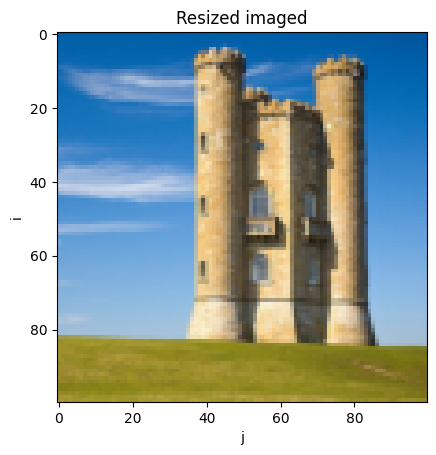

In [3]:
my_img = imread('input/640px-Broadway_tower_edit.jpg') # https://commons.wikimedia.org/wiki/File:Broadway_tower_edit.jpg#/media/File:Broadway_tower_edit.jpg
height = 100
my_img = resize(my_img, (height, my_img.shape[1]*height/my_img.shape[0]))

plt.imshow(my_img)
plt.title('Resized imaged')
plt.ylabel('i')
plt.xlabel('j')
plt.show()

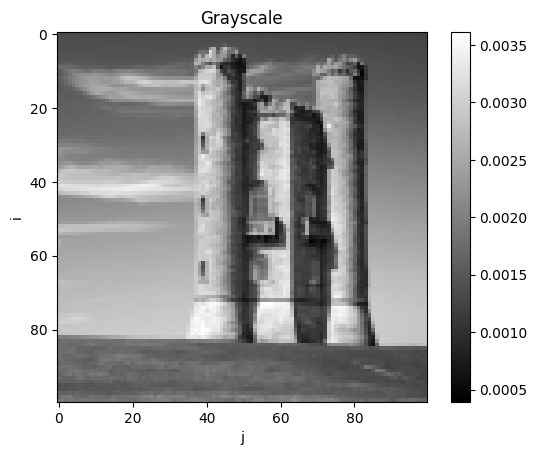

In [4]:
img_grayscale = lambda img : (img[:,:,0].astype(float) + img[:,:,1].astype(float) + img[:,:,2].astype(float))/3
img_gray = img_grayscale(my_img)
img_gray /= 255

plt.imshow(img_gray, cmap='gray')
plt.title('Grayscale')
plt.ylabel('i')
plt.xlabel('j')
plt.colorbar()
plt.show()

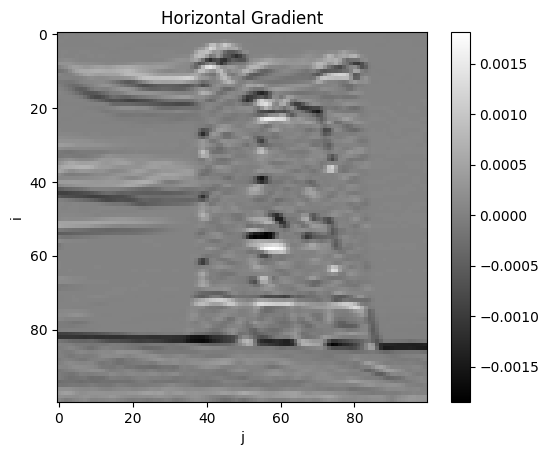

In [5]:
img_gray_grad_h = sobel_h(img_gray)

plt.imshow(img_gray_grad_h, cmap='gray')
plt.title('Horizontal Gradient')
plt.ylabel('i')
plt.xlabel('j')
plt.colorbar()
plt.show()

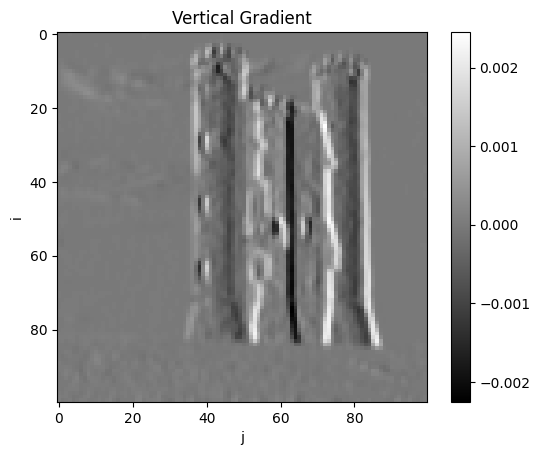

In [6]:
img_gray_grad_v = sobel_v(img_gray)

plt.imshow(img_gray_grad_v, cmap='gray')
plt.title('Vertical Gradient')
plt.ylabel('i')
plt.xlabel('j')
plt.colorbar()
plt.show()

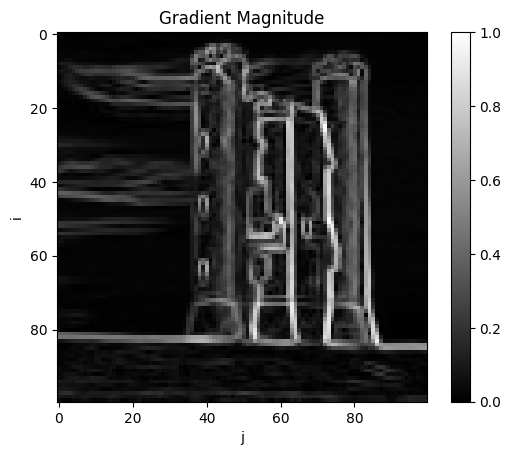

In [7]:
def img_gradient_magnitude(img):
    grad_h = sobel_h(img)
    grad_v = sobel_v(img)
    gmag = np.sqrt(grad_h**2 + grad_v**2)
    gmag -= np.min(gmag)
    gmag /= np.max(gmag)
    return gmag

img_gray_gmag = img_gradient_magnitude(img_gray)
plt.imshow(img_gray_gmag, cmap='gray')
plt.title('Gradient Magnitude')
plt.ylabel('i')
plt.xlabel('j')
plt.colorbar()
plt.show()

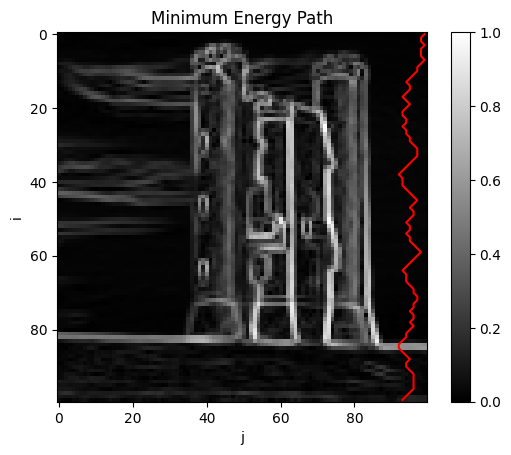

In [8]:
def min_energy_vertical_path(img_energy):
    # Function to find the minimum energy vertical path in the image
    paths = np.zeros(shape=img_energy.T.shape, dtype=int)
    paths_energies = img_energy[0, :].copy()

    for j in range(img_energy.shape[1]): # For each column
        paths[j, 0] = j # j is the first horizontal index of the current path
        k = j # this variable stores the last horizontal index chosen
        for i in range(1, img_energy.shape[0]): # For each row
            # Find the horizontal index of the lowest energy neighbor below
            # This index is assigned to l
            if k > 0 and img_energy[i, k-1] < img_energy[i, k]:
                l = k-1
            else:
                l = k
            if k < img_energy.shape[1]-1 and img_energy[i, k+1] < img_energy[i, l]:
                l = k + 1

            paths[j, i] = l # Add the current horizontal index chosen to the j-th path
            paths_energies[j] = paths_energies[j] + img_energy[i, l]  # Update the total energy of the j-th path
            k = l # Update k

    min_energy_path_i = np.arange(img_energy.shape[0])
    min_energy_path_j = paths[np.argmin(paths_energies), :]
    min_energy_path_ij = list(zip(min_energy_path_i, min_energy_path_j))
    return min_energy_path_ij, min_energy_path_i, min_energy_path_j, np.min(paths_energies)

# Function test
vpath, vpath_i, vpath_j, _ = min_energy_vertical_path(img_gray_gmag)
plt.imshow(img_gray_gmag, cmap='gray')
plt.plot(vpath_j, vpath_i, color='red')
plt.title('Minimum Energy Path')
plt.ylabel('i')
plt.xlabel('j')
plt.colorbar()
plt.show()

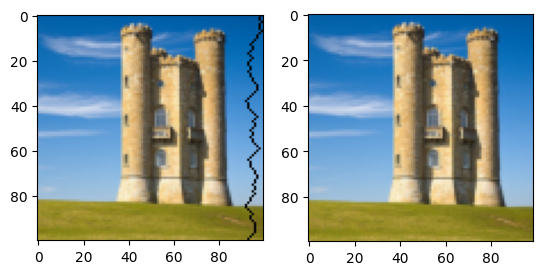

In [9]:
def remove_vpath_from_img(img, j_array):
    # Function to remove a vertical path from the image
    assert img.shape[0] == j_array.shape[0]
    def process_channel(imgc):
        rows = []
        for i in range(imgc.shape[0]):
            row_left_part = imgc[i, :j_array[i]]
            row_right_part = imgc[i, j_array[i]+1:]
            rows.append(np.append(row_left_part, row_right_part))
        return np.vstack(rows)

    img2 = np.zeros(shape=(img.shape[0], img.shape[1]-1, img.shape[2]))
    for channel in range(img.shape[2]):
        img2[:, :, channel] = process_channel(img[:, :, channel])

    return img2

# Function test
my_img_ = my_img.copy()
for i, j in vpath:
    my_img_[i,j,:] = 0
fig, ax = plt.subplots(ncols=2)
ax[0].imshow(my_img_)
ax[1].imshow(remove_vpath_from_img(my_img_, vpath_j))
plt.show()

In [10]:
def make_animation(n_frames=my_img.shape[1]//2, max_path_energy = 10):
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8,8), constrained_layout=True)
    fig.suptitle('Smart Image Resizing with Seam Carving (by Filipe Chagas)')

    ax[0,0].set_title('Image resized by Linear Interpolation')
    ax[0,1].set_title('Image resized by Seam Carving')
    ax[1,0].set_title('Path total energy')
    ax[1,1].set_title('Current minimum energy path')

    imax0 = ax[0,0].imshow(my_img)
    imax1 = ax[0,1].imshow(my_img)
    imax2 = ax[1,1].imshow(img_gray_gmag, cmap='gray')
    lineax0, = ax[1,0].plot([0], [0])
    ax[1,0].set_xlim(0, n_frames)
    ax[1,0].set_ylim(0, max_path_energy)
    ax[1,0].grid()
    lineax1, = ax[1,1].plot([0], [0], color='red')

    resized_imgs = [my_img]
    en = []
    def animate(k):
        resized_img = resized_imgs[-1]
        resized_img_gray = img_grayscale(resized_img)
        resized_img_energy = img_gradient_magnitude(resized_img_gray)
        vpath, vpath_i, vpath_j, vpath_en = min_energy_vertical_path(resized_img_energy)
        en.append(vpath_en)

        imax0.set_data(np.concatenate([resize(my_img, (my_img.shape[0], my_img.shape[1]-k)), np.ones(shape=(vpath_i.shape[0], k, 3))], axis=1))
        imax1.set_data(np.concatenate([resized_img, np.ones(shape=(vpath_i.shape[0], k, 3))], axis=1))
        imax2.set_data(np.concatenate([resized_img_energy, np.ones(shape=(vpath_i.shape[0], k))], axis=1))
        lineax0.set_data(np.arange(len(en)), en)
        lineax1.set_data(vpath_j, vpath_i)

        resized_imgs.append(remove_vpath_from_img(resized_img, vpath_j))

    return FuncAnimation(fig, animate, frames=n_frames)

ani = make_animation()
plt.close()
ani.save('output/seam-carving-filipe.gif')

MovieWriter ffmpeg unavailable; using Pillow instead.


In [11]:
HTML('<img src="output/seam-carving-filipe.gif">')